In [ ]:
import os
import h5py
import numpy as np
import math

from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from scipy.signal import fftconvolve
from skimage.feature import peak_local_max
%matplotlib inline
import matplotlib.pyplot as plt
from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D, CircleOverlap,CircleDetection,find_peaks,RemoveArtifacts

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from scipy.ndimage import maximum_filter

from skimage.transform import probabilistic_hough_line

from math import hypot, acos, sqrt, pi

from skimage.draw import disk
from skimage.segmentation import morphological_geodesic_active_contour as mgac
from skimage.filters import sobel
from skimage.restoration import inpaint

In [1]:
import h5py
import math
import os

import numpy as np
import matplotlib.pyplot as plt

from helpers import sech, normalize, ipf3D, convolution3D_FFTdomain, chiimg3D_FFT, findpeaks3D, pgrid3D, cidp23D, CircleOverlap,CircleDetection,find_peaks,RemoveArtifacts
from scipy.ndimage import median_filter, gaussian_filter, zoom
from skimage import exposure
from skimage.feature import canny


In [2]:
def sech(x): 
    return 1 / np.cosh(x)

def normalize(img): 
    return np.clip((img - img.min()) / (img.max() - img.min()), 0, 1)

def ipf3D(cr, D, w): 
    return (1 - np.tanh((np.abs(cr) - D/2)/w)) / 2

def convolution3D_FFTdomain(img, kernel): 
    return fftconvolve(img, kernel, mode='same')

def chiimg3D_FFT(img, ip, W=None, Wip2=None):
    if W is None: 
        W = ip
    if Wip2 is None: 
        Wip2 = convolution3D_FFTdomain(np.ones_like(img), ip**2 * W)
    return 1 + (-2*convolution3D_FFTdomain(img, ip*W) + convolution3D_FFTdomain(img**2, W))/Wip2, Wip2

def findpeaks3D(img, CutOff=0, MinSep=1):
    coords = peak_local_max(img, min_distance=int(MinSep), threshold_abs=CutOff)
    spx, spy, spz = coords[:, 2], coords[:, 1], coords[:, 0]  # XYZ
    return len(spx), spx, spy, spz

def pgrid3D(spx, spy, spz, Nx, Ny, Nz, Np, radLen, rad):
    over = np.zeros((Ny, Nx, Nz), dtype=int)
    cr = type('', (), {})()
    cr.x = np.zeros((Ny, Nx, Nz))
    cr.y = np.zeros((Ny, Nx, Nz))
    cr.z = np.zeros((Ny, Nx, Nz))
    for np_idx in range(Np):
        xi = np.clip(np.round(spx[np_idx]) + np.arange(-radLen, radLen+1), 0, Nx-1).astype(int)
        yi = np.clip(np.round(spy[np_idx]) + np.arange(-radLen, radLen+1), 0, Ny-1).astype(int)
        zi = np.clip(np.round(spz[np_idx]) + np.arange(-radLen, radLen+1), 0, Nz-1).astype(int)
        XX, YY, ZZ = np.meshgrid(xi, yi, zi, indexing='ij')
        crx, cry, crz = XX - spx[np_idx], YY - spy[np_idx], ZZ - spz[np_idx]
        dist = np.sqrt(crx**2 + cry**2 + crz**2)
        mask = dist < np.sqrt(cr.x[YY,XX,ZZ]**2 + cr.y[YY,XX,ZZ]**2 + cr.z[YY,XX,ZZ]**2)
        over[YY[mask], XX[mask], ZZ[mask]] = np_idx + 1
        cr.x[YY[mask], XX[mask], ZZ[mask]] = crx[mask]
        cr.y[YY[mask], XX[mask], ZZ[mask]] = cry[mask]
        cr.z[YY[mask], XX[mask], ZZ[mask]] = crz[mask]
    return cr, over

def cidp23D(cxyz, over, di, Np, D, w):
    w = 1/w
    maxdr = 2
    dpx = np.zeros(Np)
    dpy = np.zeros(Np)
    dpz = np.zeros(Np)
    rr = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2) + 1e-12
    tanh1 = np.tanh((rr - D/2)*w)
    sech2 = sech((rr - D/2)*w)**2
    dipx = -w*cxyz.x*sech2/(2*rr)
    dipy = -w*cxyz.y*sech2/(2*rr)
    dipz = -w*cxyz.z*sech2/(2*rr)
    dipxx = w*sech2*(2*w*cxyz.x**2*rr*tanh1 - cxyz.y**2 - cxyz.z**2)/(2*rr**3)
    dipyy = w*sech2*(2*w*cxyz.y**2*rr*tanh1 - cxyz.x**2 - cxyz.z**2)/(2*rr**3)
    dipzz = w*sech2*(2*w*cxyz.z**2*rr*tanh1 - cxyz.x**2 - cxyz.y**2)/(2*rr**3)
    dipxy = w*cxyz.x*cxyz.y*sech2*(2*w*rr*tanh1+1)/(2*rr**3)
    dipxz = w*cxyz.x*cxyz.z*sech2*(2*w*rr*tanh1+1)/(2*rr**3)
    dipyz = w*cxyz.y*cxyz.z*sech2*(2*w*rr*tanh1+1)/(2*rr**3)
    overVec, diVec = over.flatten(), di.flatten()
    dipxVec, dipyVec, dipzVec = dipx.flatten(), dipy.flatten(), dipz.flatten()
    dipxxVec, dipyyVec, dipzzVec = dipxx.flatten(), dipyy.flatten(), dipzz.flatten()
    dipxyVec, dipxzVec, dipyzVec = dipxy.flatten(), dipxz.flatten(), dipyz.flatten()
    for np_idx in range(Np):
        idx = np.where(overVec == np_idx + 1)[0]
        b = np.array([np.sum(diVec[idx]*dipxVec[idx]),
                      np.sum(diVec[idx]*dipyVec[idx]),
                      np.sum(diVec[idx]*dipzVec[idx])])
        A = np.array([[np.sum(dipxVec[idx]**2 + diVec[idx]*dipxxVec[idx]),
                       np.sum(dipxVec[idx]*dipyVec[idx] + diVec[idx]*dipxyVec[idx]),
                       np.sum(dipxVec[idx]*dipzVec[idx] + diVec[idx]*dipxzVec[idx])],
                      [np.sum(dipxVec[idx]*dipyVec[idx] + diVec[idx]*dipxyVec[idx]),
                       np.sum(dipyVec[idx]**2 + diVec[idx]*dipyyVec[idx]),
                       np.sum(dipyVec[idx]*dipzVec[idx] + diVec[idx]*dipyzVec[idx])],
                      [np.sum(dipxVec[idx]*dipzVec[idx] + diVec[idx]*dipxzVec[idx]),
                       np.sum(dipyVec[idx]*dipzVec[idx] + diVec[idx]*dipyzVec[idx]),
                       np.sum(dipzVec[idx]**2 + diVec[idx]*dipzzVec[idx])]])
        dp = b @ np.linalg.pinv(A + 1e-6*np.eye(3))
        stepMag = np.linalg.norm(dp)
        if stepMag > maxdr: dp = dp/max(stepMag,1e-12)*maxdr
        dpx[np_idx], dpy[np_idx], dpz[np_idx] = dp
    return dpx, dpy, dpz

def CircleOverlap(c1, c2):
    x1, y1, r1 = c1
    x2, y2, r2 = c2
    d = hypot(x1 - x2, y1 - y2)

    if d >= r1 + r2:  # No overlap
        return 0.0
    if d <= abs(r1 - r2):  # One inside the other
        return (pi * min(r1, r2)**2) / (pi * max(r1, r2)**2)

    r1_sq = r1**2
    r2_sq = r2**2

    alpha = acos((d**2 + r1_sq - r2_sq) / (2 * d * r1))
    beta = acos((d**2 + r2_sq - r1_sq) / (2 * d * r2))

    area1 = r1_sq * alpha
    area2 = r2_sq * beta
    area3 = 0.5 * sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))

    intersection = area1 + area2 - area3
    union = pi * r1_sq + pi * r2_sq - intersection
    return intersection / union

def CircleOverlap(c1, c2):
    # simple IoU-like overlap (replace with your actual implementation)
    x1, y1, r1 = c1
    x2, y2, r2 = c2
    d = np.hypot(x1 - x2, y1 - y2)
    if d > r1 + r2:
        return 0.0
    return 1.0 - d / (r1 + r2)

def CircleDetection(
    img,
    min_r=10,
    max_r=60,
    step=2,
    sigma=2.75,
    threshold=100,
    iou_thresh=0.25
):
    # Step 1: Edge detection
    img = img
    edges = canny(img, sigma=sigma)
    h, w = edges.shape

    # Step 2: Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Step 3: Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx_all = np.round(radii[:, None] * cos_t).astype(int)
    dy_all = np.round(radii[:, None] * sin_t).astype(int)

    # Step 4: Voting (vectorized)
    y_idxs, x_idxs = np.nonzero(edges)  # edge points (N,)
    N = len(x_idxs)

    # Expand edge coords against circle offsets
    # Shape: (num_radii, N, num_theta)
    x_c = x_idxs[None, :, None] - dx_all[:, None, :]
    y_c = y_idxs[None, :, None] - dy_all[:, None, :]

    # Keep only valid centers
    valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)

    # Flatten into 1D indices for bincount
    flat_idx = (y_c * w + x_c) * num_radii + np.arange(num_radii)[:, None, None]
    flat_idx = np.where(valid, flat_idx, -1).ravel()

    flat_idx = flat_idx[flat_idx >= 0]  # remove invalid

    accumulator = np.bincount(flat_idx, minlength=h * w * num_radii).reshape(h, w, num_radii)

    # Step 5: Candidate detection
    candidates = []
    for r_index, r in enumerate(radii):
        acc_slice = accumulator[:, :, r_index]
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(mask)

        if coords.size > 0:
            vals = acc_slice[coords[:, 0], coords[:, 1]]
            for (y, x), val in zip(coords, vals):
                neighbors = []
                for offset in [-2, -1, 1, 2]:
                    neighbor_idx = r_index + offset
                    if 0 <= neighbor_idx < num_radii:
                        neighbors.append(accumulator[y, x, neighbor_idx])
                if all(val > n for n in neighbors):
                    candidates.append((x, y, r, val))

    # Step 6: IoU filtering
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):
        this_circle = (x, y, r)
        keep = True
        for fx, fy, fr in final_circles:
            if CircleOverlap(this_circle, (fx, fy, fr)) > iou_thresh:
                keep = False
                break
        if keep:
            final_circles.append(this_circle)

    return final_circles

def find_peaks(a):
  x = np.array(a)
  max = np.max(x)
  length = len(a)
  ret = []
  for i in range(length):
      ispeak = True
      if i-1 > 0:
          ispeak &= (x[i] > 1.8 * x[i-1])
      if i+1 < length:
          ispeak &= (x[i] > 1.8 * x[i+1])
    
      ispeak &= (x[i] > 0.05 * max)
      if ispeak:
          ret.append(i)
  return ret

def RemoveArtifacts(img, circles, radius_padding=3):

    cleaned = img.copy()
    gradient = sobel(img)

    for x, y, r in circles:
        # Step 1: Create initial mask from circle
        rr, cc = disk((y, x), r - radius_padding, shape=img.shape)
        init_mask = np.zeros(img.shape, dtype=bool)
        init_mask[rr, cc] = True

        # Step 2: Refine region using active contour
        snake = mgac(
            gradient,        # image
            1,              # iterations
            init_mask,       # initial level set
            smoothing=1,
            threshold='auto',
            balloon=-5
        )
        refined_mask = snake > 0.5

        # Step 3: Fill internal noise (e.g., laser lines) inside the particle
        region_vals = img[refined_mask]
        counts, bin_edges = np.histogram(region_vals.flatten(), bins = 20)
        common_val_idx = np.argmax(counts)
        common_val = bin_edges[common_val_idx]
        
        noise = (refined_mask & (img < common_val - 0.05))
        cleaned[noise] = common_val*1.2

    return cleaned


In [3]:
filePath = r"./Scan_162.hdf5"
dataPath = f'/RawData/Scan_162'

with h5py.File(filePath,'r') as f: 
    data = f[dataPath][()] # (slices, rows, width)
data = np.transpose(data,[1,2,0]) # (rows, width, slices)
dataCropped = data[150:1100,50:970,:]
cR, cW, cZ = np.shape(dataCropped)

In [4]:
highPct, medPct = 99, 95

# Apply median filter and threshold
threshHigh = np.percentile(dataCropped, highPct)
filteredData = median_filter(dataCropped, size=(3, 3, 3))
dataCropped[dataCropped > threshHigh] = filteredData[dataCropped > threshHigh]

# Update threshold and replace values above it with the median
threshHigh = np.percentile(dataCropped, highPct)
dataCropped[dataCropped > threshHigh] = np.mean(np.percentile(dataCropped, medPct))


In [5]:
meanPerCol = np.mean(dataCropped,axis=(1,2))
meanCenterRow = meanPerCol[math.floor(cR/2)]
scales = meanCenterRow/meanPerCol

dataColNorm = dataCropped*scales[:, np.newaxis, np.newaxis]
dataNorm = np.clip(exposure.rescale_intensity(dataColNorm, in_range='image', out_range=(0,1)), 0, 1)

blurred = gaussian_filter(dataNorm, sigma=3)
strength = 0.2
dataSharp = np.clip(dataNorm + strength * blurred, 0, 1)

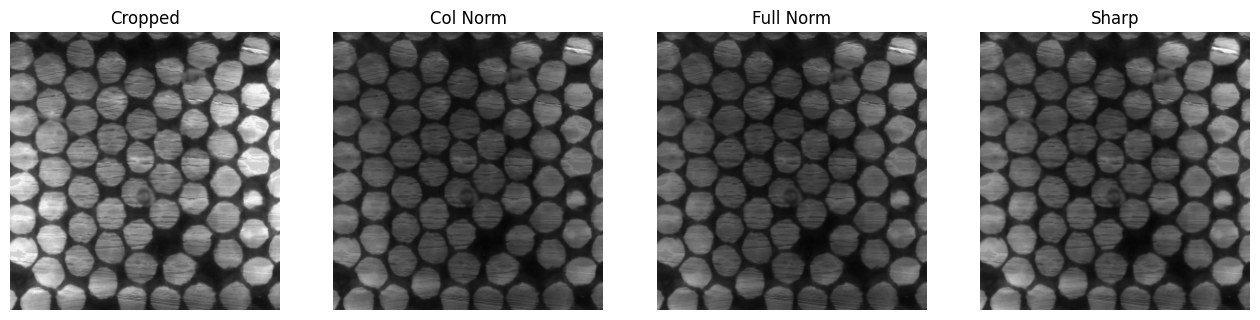

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) 
ax1, ax2, ax3, ax4 = axs.flatten()

ax1.imshow(dataCropped[:, :, math.floor(cZ/2)], cmap='gray')
ax2.imshow(dataColNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax3.imshow(dataNorm[:, :, math.floor(cZ/2)], cmap='gray')
ax4.imshow(dataSharp[:, :, math.floor(cZ/2)], cmap='gray')

ax1.set_title('Cropped')
ax2.set_title('Col Norm')
ax3.set_title('Full Norm')
ax4.set_title('Sharp')

for ax in axs:
    ax.axis('off')

plt.show()

In [ ]:
# Download processed data
data = dataSharp
with h5py.File('processed_162.hdf5', 'w') as f: 
    dset = f.create_dataset("default", data)

In [ ]:
# Read processed data
with h5py.File(r'processed_162.hdf5','r') as f: 
    data = f['default'][:] # (slices, rows, width)

In [37]:
# Downsample
scaleFactor = 0.25
dataRescale = zoom(dataSharp, scaleFactor, order=1)
print(np.shape(dataRescale))

(238, 230, 213)


In [42]:
def SphereDetection(volume, min_r=10, max_r=60, step=2, sigma=2.75, threshold=100, iou_thresh=0.25):

    # Edge detection
    edges = np.array([canny(img,sigma=sigma) for img in volume])
    r, c, s = edges.shape

    # Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    print(radii)
    print(radii[:,None])

    # Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    dx_all = np.round(radii[:, None] * np.cos(theta)).astype(int)
    dy_all = np.round(radii[:, None] * np.sin(theta)).astype(int)

SphereDetection(dataRescale)

[10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56
 58]
[[10]
 [12]
 [14]
 [16]
 [18]
 [20]
 [22]
 [24]
 [26]
 [28]
 [30]
 [32]
 [34]
 [36]
 [38]
 [40]
 [42]
 [44]
 [46]
 [48]
 [50]
 [52]
 [54]
 [56]
 [58]]


NameError: name 'pi' is not defined

In [ ]:
def SphereDetection(volume, min_r=10,max_r=60,step=2,sigma=2.75,threshold=100,iou_thresh=0.25):
    # Edge detection
    edges = [canny(img,sigma=sigma) for img in volume]
    h, w = edges.shape

    # Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx_all = np.round(radii[:, None] * cos_t).astype(int)
    dy_all = np.round(radii[:, None] * sin_t).astype(int)

    # Voting
    y_idxs, x_idxs = np.nonzero(edges)  # edge points (N,)
    N = len(x_idxs)

    # Expand edge coords against circle offsets
    # Shape: (num_radii, N, num_theta)
    x_c = x_idxs[None, :, None] - dx_all[:, None, :]
    y_c = y_idxs[None, :, None] - dy_all[:, None, :]

    # Keep only valid centers
    valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)

    # Flatten into 1D indices for bincount
    flat_idx = (y_c * w + x_c) * num_radii + np.arange(num_radii)[:, None, None]
    flat_idx = np.where(valid, flat_idx, -1).ravel()

    flat_idx = flat_idx[flat_idx >= 0]  # remove invalid

    accumulator = np.bincount(flat_idx, minlength=h * w * num_radii).reshape(h, w, num_radii)

    # Candidate detection
    candidates = []
    for r_index, r in enumerate(radii):
        acc_slice = accumulator[:, :, r_index]
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(mask)

        if coords.size > 0:
            vals = acc_slice[coords[:, 0], coords[:, 1]]
            for (y, x), val in zip(coords, vals):
                neighbors = []
                for offset in [-2, -1, 1, 2]:
                    neighbor_idx = r_index + offset
                    if 0 <= neighbor_idx < num_radii:
                        neighbors.append(accumulator[y, x, neighbor_idx])
                if all(val > n for n in neighbors):
                    candidates.append((x, y, r, val))

    # IoU filtering
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):
        this_circle = (x, y, r)
        keep = True
        for fx, fy, fr in final_circles:
            if CircleOverlap(this_circle, (fx, fy, fr)) > iou_thresh:
                keep = False
                break
        if keep:
            final_circles.append(this_circle)

    return final_circles

In [ ]:
def CircleDetection(
    img,
    min_r=10,
    max_r=60,
    step=2,
    sigma=2.75,
    threshold=100,
    iou_thresh=0.25
):
    # Edge detection
    edges = canny(img, sigma=sigma)
    h, w = edges.shape

    # Radii
    radii = np.arange(min_r, max_r, step)
    num_radii = len(radii)

    # Precompute circle perimeters (stacked)
    theta = np.arange(0, 2 * pi, pi / 180)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx_all = np.round(radii[:, None] * cos_t).astype(int)
    dy_all = np.round(radii[:, None] * sin_t).astype(int)

    # Voting
    y_idxs, x_idxs = np.nonzero(edges)  # edge points (N,)
    N = len(x_idxs)

    # Expand edge coords against circle offsets
    # Shape: (num_radii, N, num_theta)
    x_c = x_idxs[None, :, None] - dx_all[:, None, :]
    y_c = y_idxs[None, :, None] - dy_all[:, None, :]

    # Keep only valid centers
    valid = (x_c >= 0) & (x_c < w) & (y_c >= 0) & (y_c < h)

    # Flatten into 1D indices for bincount
    flat_idx = (y_c * w + x_c) * num_radii + np.arange(num_radii)[:, None, None]
    flat_idx = np.where(valid, flat_idx, -1).ravel()

    flat_idx = flat_idx[flat_idx >= 0]  # remove invalid

    accumulator = np.bincount(flat_idx, minlength=h * w * num_radii).reshape(h, w, num_radii)

    # Candidate detection
    candidates = []
    for r_index, r in enumerate(radii):
        acc_slice = accumulator[:, :, r_index]
        local_max = (maximum_filter(acc_slice, size=5) == acc_slice)
        mask = (acc_slice > threshold) & local_max
        coords = np.argwhere(mask)

        if coords.size > 0:
            vals = acc_slice[coords[:, 0], coords[:, 1]]
            for (y, x), val in zip(coords, vals):
                neighbors = []
                for offset in [-2, -1, 1, 2]:
                    neighbor_idx = r_index + offset
                    if 0 <= neighbor_idx < num_radii:
                        neighbors.append(accumulator[y, x, neighbor_idx])
                if all(val > n for n in neighbors):
                    candidates.append((x, y, r, val))

    # IoU filtering
    final_circles = []
    for x, y, r, val in sorted(candidates, key=lambda c: -c[3]):
        this_circle = (x, y, r)
        keep = True
        for fx, fy, fr in final_circles:
            if CircleOverlap(this_circle, (fx, fy, fr)) > iou_thresh:
                keep = False
                break
        if keep:
            final_circles.append(this_circle)

    return final_circles

In [18]:
circles = CircleDetection(img_as_ubyte(image),threshold=60)

NameError: name 'img_as_ubyte' is not defined

In [ ]:
clean = RemoveArtifacts(mid, circles)

In [ ]:
clean_bin = np.copy(clean)
clean_bin[clean_bin<.3] =0
clean_bin[clean_bin>=.3]=1

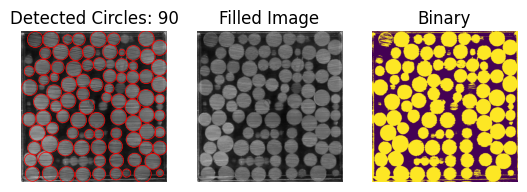

In [ ]:
# Plot results
fig, axs = plt.subplots(1,3)
ax1, ax2, ax3 = axs.flatten()

ax1.imshow(image, cmap='gray')
ax2.imshow(clean, cmap='gray')
ax3.imshow(clean_bin)

for x, y, r in circles:
    circle = plt.Circle((x, y), r, color='red', fill=False, linewidth=.5)
    ax1.add_patch(circle)

for ax in axs:
    ax.set_axis_off()

ax1.set_title(f"Detected Circles: {len(circles)}")
ax2.set_title("Filled Image")
ax3.set_title("Binary")

plt.show()

Text(0.5, 1.0, 'Binary Filled')

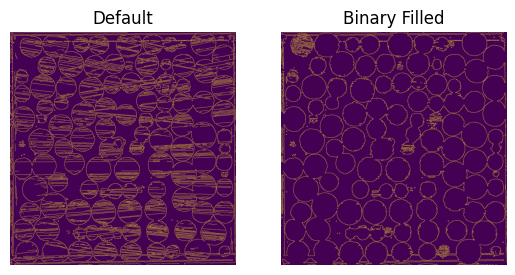

In [ ]:
fig, axs = plt.subplots(1,2)
ax1,ax2 =axs.flatten()

ax1.imshow(canny(image))
ax2.imshow(canny(clean_bin))

for ax in axs:
    ax.set_axis_off()

ax1.set_title('Default')
ax2.set_title('Binary Filled')

In [ ]:
plt.hist(image)


NameError: name 'plt' is not defined

In [ ]:
# Downsample
scaleFactor = 0.5
dataRescale = zoom(dataSharp, scaleFactor, order=1)

In [ ]:

# Particle detection

D, w = 100*scaleFactor, 2.5*scaleFactor
Cutoff, MinSep = 5, 75*scaleFactor
ss = int(2*(D/2 + 4*w/2)-1)
os = (ss-1)//2
xx, yy, zz = np.meshgrid(np.arange(-os,os+1), np.arange(-os,os+1), np.arange(-os,os+1), indexing='ij')
r = np.sqrt(xx**2 + yy**2 + zz**2)
ipi = ipf3D(r, D, w)
chi3D, _ = chiimg3D_FFT(dataRescale, ipi)
Np, px, py, pz = findpeaks3D(1./(chi3D+1e-12), Cutoff=Cutoff, MinSep=MinSep)

In [ ]:
# Sub-voxel refinement
cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
ci = ipf3D(r_full, D, w)
di = ci - dataRescale
chi2 = np.sum(di**2)

nr, delchi2, mindelchi2, maxnr = 0, 1e99, 1, 5
while abs(delchi2)>mindelchi2 and nr<maxnr:
    dpx, dpy, dpz = cidp23D(cxyz, over, di, Np, D, w)
    px += dpx; py += dpy; pz += dpz
    cxyz, over = pgrid3D(px, py, pz, dataRescale.shape[1], dataRescale.shape[0], dataRescale.shape[2], Np, os, 0)
    r_full = np.sqrt(cxyz.x**2 + cxyz.y**2 + cxyz.z**2)
    ci = ipf3D(r_full, D, w)
    di = ci - dataRescale
    delchi2 = chi2 - np.sum(di**2)
    chi2 -= delchi2
    nr += 1

In [ ]:

# Visualization

# Max projection of residual
plt.figure()
plt.imshow(np.max(di**2, axis=2), cmap='gray', origin='lower')
plt.colorbar()
plt.title(f'Residual Chi^2 (max projection), Chi2={chi2:.2f}')
plt.show()

In [ ]:
# 3D scatter of particle centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px, py, pz, c='r', s=50)
ax.set_xlim(0, dataRescale.shape[1])
ax.set_ylim(0, dataRescale.shape[0])
ax.set_zlim(0, dataRescale.shape[2])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Detected particle centers')
plt.show()
